# Summarize WSF

The World Settlement Footprint was officially launched in November 2021, [see the announcement here for more details](https://www.esa.int/Applications/Observing_the_Earth/Mapping_our_human_footprint_from_space).

GOST have downloaded the evolution dataset, generated a VRT combining the ~5000 tiles, and uploaded to our private AWS bucket (wbgdecinternal-ntl). That dataset will be used to summarize change in the built up area in a variety of urban areas

In [1]:
import sys, os, importlib
import rasterio

import pandas as pd
import geopandas as gpd

try:
    import GOSTRocks.rasterMisc as rMisc    
    from GOSTRocks.misc import tPrint
except:
    print("Cannot find GOSTRocks")


In [2]:
wsf_evolution = 's3://wbgdecinternal-ntl/GIS_Data/GLOBAL/WSFEvolution/WSF_Evolution.vrt'
urban_extents = '/home/public/Data/GLOBAL/URBAN/GHS/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg'
out_folder = "/home/wb411133/data/Projects/SD_FLAGSHIP/Data/GHS_URB_RES"
WSF_summary_file = os.path.join(out_folder, "WSF_Evolution.csv")

#Columns in urban database to keep in output - includes ID column and names
inD_cols = ['ID_HDC_G0','CTR_MN_NM','CTR_MN_ISO','UC_NM_MN', 'UC_NM_LST'] 
unq_vals = [0] + list(range(1985, 2016))

In [3]:
inR = rasterio.open(wsf_evolution)
inD = gpd.read_file(urban_extents)

In [ ]:
if not os.path.exists(WSF_summary_file):
    res = rMisc.zonalStats(inD, inR, rastType='C', unqVals=unq_vals)

    named = pd.DataFrame(res, columns=[f'c_{x}' for x in unq_vals])
    for col in inD_cols:
        named[col] = inD[col]

    named.to_csv(WSF_summary_file)

# Map some results

In [76]:
import folium, matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown, HTML, FileLink, FileLinks
from matplotlib import cm

In [131]:
def generate_city_map(city_name, inD, inR, WSF_summary_file, out_folder, colorscale = cm.magma, chart_style = "darkgrid"):
    # Select a single city in the dataset
    sel_city = inD.loc[inD['UC_NM_MN'] == city_name]
    if sel_city.shape[0] != 1:
        raise(ValueError(f'Selected city returned {sel_city.shape[0]} records'))
    
    #Extract WSF for the desired area
    geometry = sel_city.unary_union
    buff_geom = geometry.buffer(0.1)
    ul = inR.index(*buff_geom.bounds[0:2])
    lr = inR.index(*buff_geom.bounds[2:4])
    window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))

    inR_data = inR.read(1, window=window, boundless=True, fill_value=0)

    #Scale data 0-255 for mapping
    plot_data = inR_data - 1984
    plot_data = (255/plot_data.max()) * plot_data
    plot_data[plot_data < 0] = -1
    plot_data = plot_data.astype(int)
    
    # Set 0 in grayscale to gray
    colour_scale = cm.magma.copy() # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    colour_scale.set_under(color='k', alpha=0.25)

    # Map the vals for the selected city
    m = folium.Map([geometry.centroid.y, geometry.centroid.x], tiles='cartodbpositron')
    b = buff_geom.bounds

    folium.raster_layers.ImageOverlay(
        image = plot_data,
        bounds = [[b[1],b[0]],[b[3],b[2]]],
        colormap=colour_scale,
        name = "WSF Evolution (1985-2015)"
    ).add_to(m)

    simple_geo = gpd.GeoSeries(geometry).to_json()
    geo_folium = folium.GeoJson(data = simple_geo, 
                               style_function = lambda x: {'fillColor': '#00000000'},
                               name = "UCDB urban extent")
    geo_folium.add_to(m)
    folium.LayerControl().add_to(m)
    
    b_new = geometry.bounds
    b_new = [x-.005 for x in b_new]
    m.fit_bounds([[b_new[1],b_new[0]],[b_new[3],b_new[2]]])
    
    chart_vals = pd.read_csv(WSF_summary_file)
    sel_chart = chart_vals.loc[chart_vals['UC_NM_MN'] == city_name]
    sel_vals = sel_chart.iloc[:,2:-5].cumsum(axis=1)
    vals = sel_vals.values
    sns.set_style(chart_style)
    xx = sel_vals.transpose().plot.line(figsize=(15,10), legend=False, title="Built area in km2")
    
    if out_folder != '':
        m.save(os.path.join(out_folder, f'WSF_Map_{city_name}.html'))
        plt.savefig(os.path.join(out_folder, f'WSF_Evolution_{city_name}.png'))
    
    return({'map':m, 'chart':xx})

In [ ]:
city_name = "Nairobi"
cur_m = generate_city_map(city_name, inD, inR, WSF_summary_file, "../images")

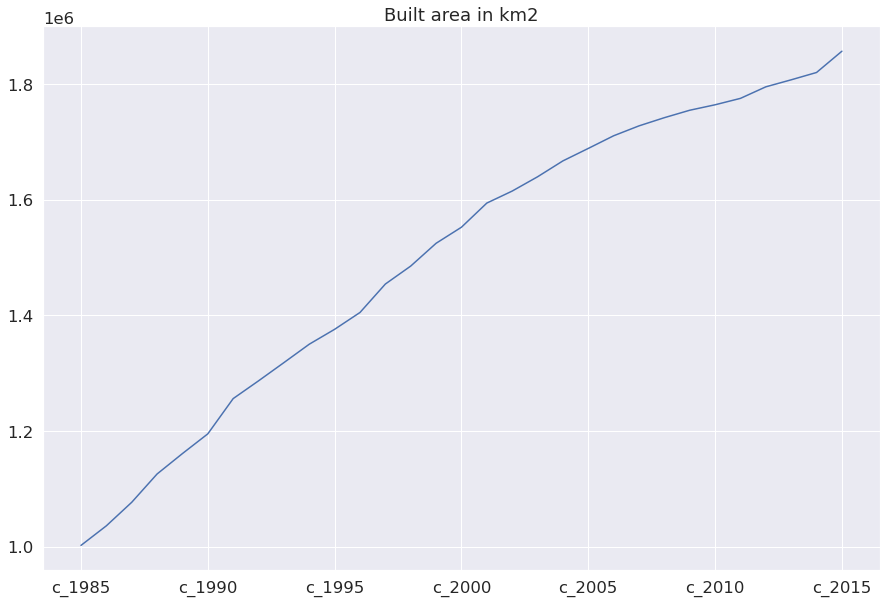

In [79]:
city_name = "Washington D.C."
cur_m = generate_city_map(city_name, inD, inR, WSF_summary_file, "../images")

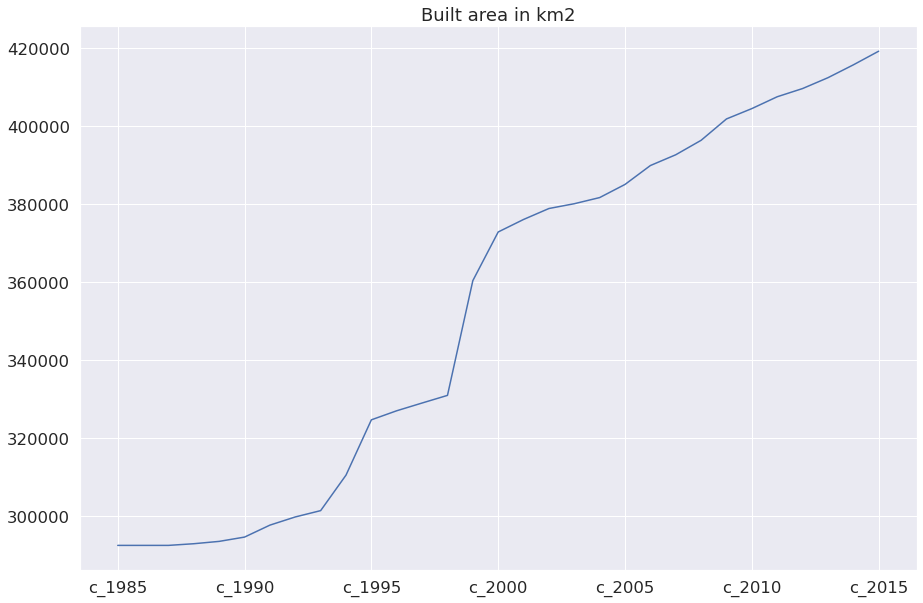

# Debugging

In [121]:
city_name = 'Halifax'
out_folder = "../images" 
colorscale = cm.magma
chart_style = "darkgrid"


In [122]:
 # Select a single city in the dataset
sel_city = inD.loc[inD['UC_NM_MN'] == city_name]
if sel_city.shape[0] != 1:
    raise(ValueError(f'Selected city returned {sel_city.shape[0]} records'))

#Extract WSF for the desired area
geometry = sel_city.unary_union
buff_geom = geometry.buffer(0.1)
ul = inR.index(*buff_geom.bounds[0:2])
lr = inR.index(*buff_geom.bounds[2:4])
window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))

inR_data = inR.read(1, window=window, boundless=True, fill_value=0)

#Scale data 0-255 for mapping
plot_data = inR_data - 1984
plot_data = (255/plot_data.max()) * plot_data
plot_data[plot_data < 0] = -1
plot_data = plot_data.astype(int)

# Set 0 in grayscale to gray
colour_scale = cm.magma.copy() # https://matplotlib.org/stable/tutorials/colors/colormaps.html
colour_scale.set_under(color='k', alpha=0.25)


In [130]:
# Map the vals for the selected city
m = folium.Map([geometry.centroid.y, geometry.centroid.x], tiles='cartodbpositron')

folium.raster_layers.ImageOverlay(
    image = plot_data,
    bounds = [[b[1],b[0]],[b[3],b[2]]],
    colormap=colour_scale,
    name = "WSF Evolution (1985-2015)"
).add_to(m)

simple_geo = gpd.GeoSeries(geometry).to_json()
geo_folium = folium.GeoJson(data = simple_geo, 
                           style_function = lambda x: {'fillColor': '#00000000'},
                           name = "UCDB urban extent")
geo_folium.add_to(m)
folium.LayerControl().add_to(m)



m

In [124]:
m.get_bounds()

[[44.511086888712924, -63.78434678933665],
 [44.812260796940905, -63.36762921115707]]

In [108]:
[[b[1],b[0]],[b[3],b[2]]]

[[44.511086888712924, -63.78434678933665],
 [44.812260796940905, -63.36762921115707]]

In [129]:
b = geometry.bounds
b = [x-.005 for x in b]
m.fit_bounds([[b[1],b[0]],[b[3],b[2]]])
m

In [126]:
b

(-63.684352853668386, 44.611086888712926, -63.46762454526054, 44.7122607969409)

In [ ]:

chart_vals = pd.read_csv(WSF_summary_file)
sel_chart = chart_vals.loc[chart_vals['UC_NM_MN'] == city_name]
sel_vals = sel_chart.iloc[:,2:-5].cumsum(axis=1)
vals = sel_vals.values
sns.set_style(chart_style)
xx = sel_vals.transpose().plot.line(figsize=(15,10), legend=False, title="Built area in km2")

if out_folder != '':
    m.save(os.path.join(out_folder, f'WSF_Map_{city_name}.html'))
    plt.savefig(os.path.join(out_folder, f'WSF_Evolution_{city_name}.png'))